# 2020-01-22

In this notebook I will be going through an enlarged data set of comments and carrying out simple NLP. Specifically topic analysis through LDA or Latent Dirichlet Allocation

Useful for emoji work:
https://medium.com/towards-artificial-intelligence/emoticon-and-emoji-in-text-mining-7392c49f596a

Useful for LDA:
https://towardsdatascience.com/a-beginners-guide-to-preprocessing-text-data-using-nlp-tools-5cb52a8d3cd
https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Pre-processing

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'shammi'])


In [3]:
insight_dir = 'C:\\Users\\Ronald Maj\\Documents\\GitHub\\InsightDataProject\\'

comms_df = pd.read_csv(insight_dir+'data\\processed\\comments_df.csv', index_col=0)
vids_df = pd.read_csv(insight_dir+'data\\processed\\videos_top30_df.csv', index_col=0)
channels_df = pd.read_csv(insight_dir+'data\\processed\\channels_top50_df.csv', index_col=0)

# Just take one channel as a test
test_cid = channels_df.iloc[1]['ChannelID']
test_vids_list = list(vids_df[vids_df['ChannelID'] == test_cid]['VidID'])

# Get just the comments from the test case
test_df = comms_df[comms_df['videoId'].isin(test_vids_list)]

In [4]:
test_commtext = test_df['textDisplay']

In [5]:
test_commtext.head(5)

0    Did I just watch two brothers legit have a "to...
1         @Shammi Vlogs I thought that was a joke, lol
2                                         Bahahahahaha
3               @Larry lmao true \n\nPs  \nIll edit it
4    Adam brothers* and the worst part about it is ...
Name: textDisplay, dtype: object

In [6]:
len(test_df)

9410

In [7]:
# Convert to list
data = test_commtext.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Did I just watch two brothers legit have a "toss" to split a tiebreak 😂😂😂']


In [8]:

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

data = [deEmojify(comm) for comm in data]

In [9]:
pprint(data[:1])

['Did I just watch two brothers legit have a "toss" to split a tiebreak ']


In [10]:
def clean_text(text):
    # lower case:
    text = text.lower()
    # replace new line and return with space
    text = text.replace("\n", " ").replace("\r"," ")
    # replace punctuation marks with space
    punc_list = '!"#$%&()*+,-./:;<=>?@[\]{}|^_~' + '0123456789'
    t=str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)
    # replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    return text

In [11]:
data = [clean_text(comm) for comm in data]

In [12]:
pprint(data[:1])

['did i just watch two brothers legit have a  toss  to split a tiebreak ']


In [13]:
from textblob import TextBlob
import numpy as np

In [14]:
blobs = []
for item in data:
    blobs.append(TextBlob(item))

In [15]:
sents = np.array([blob.sentiment.polarity for blob in blobs])

In [16]:
np.mean(sents)

0.15988229351205194

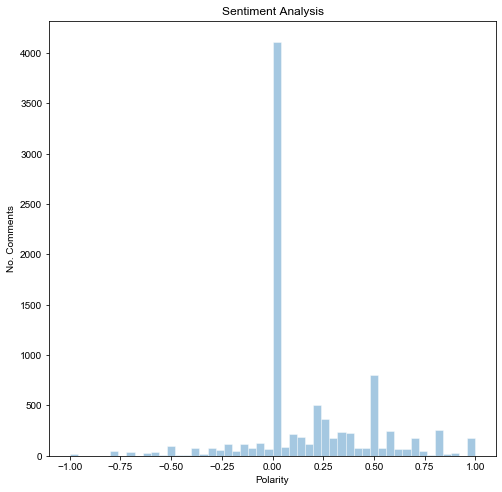

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(8, 8))
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('No. Comments')
sns.set_style('darkgrid')
sns.distplot(sents,kde=False)

In [18]:
# Remove all neutral sentiments as they do not contribute much to gauging overall sentiment
sents_rm_neu = [x for x in sents if x != 0]

In [19]:
sents_rm_neu[0:10]

[0.8, 0.15, -1.0, 0.6, 0.25, 0.2, -0.125, 0.25, 0.44999999999999996, -0.15]

In [20]:
np.mean(sents_rm_neu)

0.28084606719216143

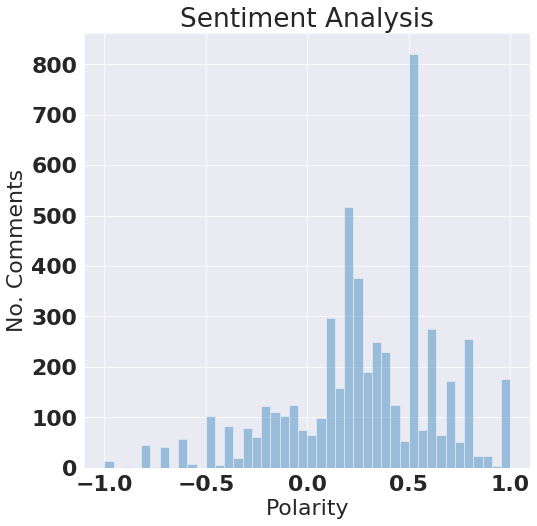

In [21]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}	
matplotlib.rc('font', **font)

plt.figure(figsize=(8, 8))
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('No. Comments')
sns.set_style('darkgrid')
sns.distplot(sents_rm_neu,kde=False)

In [22]:
# Number of comments above 

In [23]:
pprint(data[:1])

['did i just watch two brothers legit have a  toss  to split a tiebreak ']


In [24]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['did', 'just', 'watch', 'two', 'brothers', 'legit', 'have', 'toss', 'to', 'split', 'tiebreak']]


In [25]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[10]]])

['lachie', 'its', 'me', 'josh', 'lmao', 'what', 'are', 'the', 'odds', 'you', 'watch', 'shammi']


In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['watch', 'brother', 'legit', 'toss', 'split', 'tiebreak']]


In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [29]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('brother', 1),
  ('legit', 1),
  ('split', 1),
  ('tiebreak', 1),
  ('toss', 1),
  ('watch', 1)]]

In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [31]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.298*"get" + 0.112*"work" + 0.104*"say" + 0.094*"still" + 0.064*"half" + '
  '0.039*"last" + 0.028*"month" + 0.025*"better" + 0.015*"hell" + '
  '0.012*"name"'),
 (1,
  '0.495*"love" + 0.194*"guy" + 0.058*"channel" + 0.049*"content" + '
  '0.045*"new" + 0.040*"challenge" + 0.001*"makin_memorie" + 0.000*"funny" + '
  '0.000*"amazing" + 0.000*"rest"'),
 (2,
  '0.176*"want" + 0.134*"upload" + 0.102*"week" + 0.094*"can" + 0.054*"run" + '
  '0.047*"straight" + 0.043*"wanna" + 0.034*"side" + 0.006*"hold" + '
  '0.003*"race"'),
 (3,
  '0.247*"look" + 0.225*"have" + 0.066*"leave" + 0.064*"home" + '
  '0.060*"youtube" + 0.033*"camera" + 0.024*"second" + 0.016*"move" + '
  '0.007*"fit" + 0.000*"chocolate"'),
 (4,
  '0.314*"video" + 0.163*"watch" + 0.157*"would" + 0.150*"make" + '
  '0.078*"happy" + 0.009*"honestly" + 0.009*"team" + 0.005*"least" + '
  '0.003*"memory" + 0.000*"lego"'),
 (5,
  '0.333*"drink" + 0.217*"train" + 0.058*"ill" + 0.046*"like" + 0.034*"dog" + '
  '0.021*"shout" +

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.19032265300262

Coherence Score:  0.453786034079125


In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.262933 -0.325058       1        1  12.649507
10    -0.218855  0.293049       2        1  10.567994
4     -0.167924  0.053958       3        1   9.540300
1     -0.149993  0.038317       4        1   9.013470
0     -0.040477  0.003345       5        1   7.368925
12    -0.055286  0.005637       6        1   6.862312
17    -0.028179  0.001821       7        1   5.974049
18    -0.008571 -0.000339       8        1   5.669679
8      0.009468 -0.002126       9        1   4.710905
6      0.034335 -0.004034      10        1   4.082618
3      0.060404 -0.005570      11        1   3.401033
9      0.076200 -0.006244      12        1   3.310321
16     0.057212 -0.005358      13        1   3.252141
13     0.075333 -0.006224      14        1   2.717757
14     0.103088 -0.007098      15        1   2.408728
19     0.102177 -0.007032      16        1   2.071847
2      0.084097 -0.006591      17        1   2.051049
5      0.075736 -0.006236      18        1   1.879150
11     0.126492 -0.007121      19        1   1.324229
7      0.127677 -0.007096      20        1   1.143980, topic_info=     Category         Freq     Term        Total  loglift  logprob
55    Default  1935.000000     love  1935.000000  30.0000   30.000
57    Default  1212.000000     good  1212.000000  29.0000   29.000
200   Default  1298.000000    video  1298.000000  28.0000   28.000
9     Default   938.000000     vlog   938.000000  27.0000   27.000
61    Default   889.000000        s   889.000000  26.0000   26.000
...       ...          ...      ...          ...      ...      ...
447   Topic20     0.062652      big     1.616578   1.2202   -8.977
339   Topic20     0.062652    prank     1.616608   1.2202   -8.977
347   Topic20     0.062652  jackson     1.616737   1.2201   -8.977
366   Topic20     0.062651  comment     1.616589   1.2202   -8.977
1570  Topic20     0.062650  because     1.616120   1.2204   -8.977

[827 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
192      14  0.988572  actually
88        2  0.831214       add
188       5  0.968214       ago
142      10  0.990996    always
97       10  0.955622  anything
...     ...       ...       ...
134       3  0.998424     would
154       1  0.975258      year
220       2  0.975758      yeww
274      11  0.978511   youtube
308      20  0.964912  youtuber

[194 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 11, 5, 2, 1, 13, 18, 19, 9, 7, 4, 10, 17, 14, 15, 20, 3, 6, 12, 8])

Try running with spaCy

In [34]:
import spacy
from spacy import displacy

# Convert to list
data_spacy = test_commtext.values.tolist()

In [35]:
data_spacy[0:5]

['Did I just watch two brothers legit have a "toss" to split a tiebreak  😂😂😂',
 '@Shammi Vlogs I thought that was a joke, lol',
 'Bahahahahaha',
 '@Larry lmao true \n\nPs  \nIll edit it',
 'Adam brothers* and the worst part about it is that they aren’t even Tasmanian!']

In [36]:
nlp = spacy.load('en_core_web_sm')
data_spacy = [nlp(doc) for doc in data_spacy]

In [37]:
data_spacy[0]

Did I just watch two brothers legit have a "toss" to split a tiebreak  😂😂😂

In [38]:
for ent in data_spacy[0].ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

two 17 20 CARDINAL


In [39]:
stops = stopwords.words("english")

def normalize(comment, lowercase=True, remove_stopwords=True):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return lemmatized



In [40]:
data_spacy = test_commtext.values.tolist()
data_spacy = [deEmojify(comm) for comm in data_spacy]

In [41]:
data_spacy[0:5]

['Did I just watch two brothers legit have a "toss" to split a tiebreak  ',
 '@Shammi Vlogs I thought that was a joke, lol',
 'Bahahahahaha',
 '@Larry lmao true \n\nPs  \nIll edit it',
 'Adam brothers* and the worst part about it is that they arent even Tasmanian!']

In [42]:
data_spacy = [clean_text(comm) for comm in data_spacy]

In [43]:
data_spacy[0:5]

['did i just watch two brothers legit have a  toss  to split a tiebreak  ',
 ' shammi vlogs i thought that was a joke  lol',
 'bahahahahaha',
 ' larry lmao true   ps   ill edit it',
 'adam brothers  and the worst part about it is that they arent even tasmanian ']

In [44]:
data_spacy = [nlp(doc) for doc in data_spacy]

In [45]:
data_spacy[0:5]

[did i just watch two brothers legit have a  toss  to split a tiebreak  ,
  shammi vlogs i thought that was a joke  lol,
 bahahahahaha,
  larry lmao true   ps   ill edit it,
 adam brothers  and the worst part about it is that they arent even tasmanian ]

In [46]:
ent_list = []
for doc in data_spacy:
    for ent in doc.ents:
        if ent.label_ == 'GPE':
            if (ent.label_ != ' ') or (ent.label_ != '  '):
                ent_list.append(ent)

In [47]:
ent_list[0:15]

[     ,
       ,
       ,
       ,
       ,
      ,
      ,
 india,
 india,
      ,
      ,
      ,
      ,
      ,
 india]

# 2020-01-23

Previous notebook version was not saved. But the summary code is below:

Investigating the sentiments of each comments, including
- deleting comments with zero polarity on the sentimality scale
- calculating the overall sentiment of channel
- dividing up to videos to gain an idea of changes in time

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


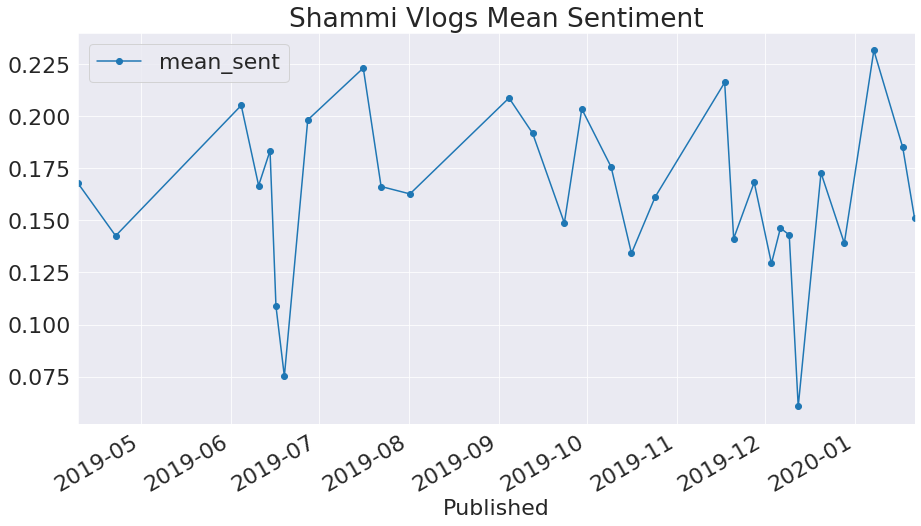

In [49]:
test_df['Sentiment_Polarity'] = sents

vid_ids = list(set(test_df['videoId']))
sent_vids = []
for vid_ID in vid_ids:
    sent_vids.append(np.array(test_df[test_df['videoId'] == vid_ID]['Sentiment_Polarity']))

sent_vids_mean = [np.mean(sent_vids[i]) for i in range(0,len(sent_vids))]

sents_df = pd.DataFrame({'VidID':vid_ids, 'mean_sent':sent_vids_mean})

vids_df = pd.read_csv(insight_dir+'data\\processed\\videos_top30_df.csv', index_col=0)

import dateparser
published = []
for vid_id in sents_df['VidID']:
    published.append(dateparser.parse(vids_df[vids_df['VidID'] == vid_id]['VidPublished'].values[0]))

sents_df['Published'] = published

sents_df = sents_df.sort_values(by='Published')

#sents_df = sents_df.set_index('Published')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

sents_df.plot.line(x='Published',y='mean_sent',figsize=(15,8), marker='o',title='Shammi Vlogs Mean Sentiment')

In [50]:
sents_df.head(5)

,VidID,mean_sent,Published
27,36Kaj2_vqeo,0.168121,2019-04-09 08:44:19+00:00
7,inBhr8E-iA0,0.142588,2019-04-22 10:03:27+00:00
20,VL7AjoWG_SI,0.205229,2019-06-04 11:36:24+00:00
14,YQt1_b56OqQ,0.166721,2019-06-10 10:56:59+00:00
19,yUJ948S0zCM,0.183459,2019-06-14 08:50:46+00:00


In [51]:
vids_df['comm_views'] = vids_df['commentCount']/vids_df['viewCount']

vids_df['like_views'] = vids_df['likeCount']/vids_df['viewCount']

vids_df['dislike_views'] = vids_df['dislikeCount']/vids_df['viewCount']

vids_df['inter_views'] = (vids_df['likeCount']+vids_df['dislikeCount']+vids_df['commentCount'])/vids_df['viewCount']

In [52]:
vids_df.head(5)[['comm_views','like_views','inter_views']]

,comm_views,like_views,inter_views
0,0.002564,0.037689,0.041181
1,0.002075,0.043185,0.045977
2,0.003585,0.050083,0.054057
3,0.001081,0.024296,0.025729
4,0.002916,0.044623,0.048072


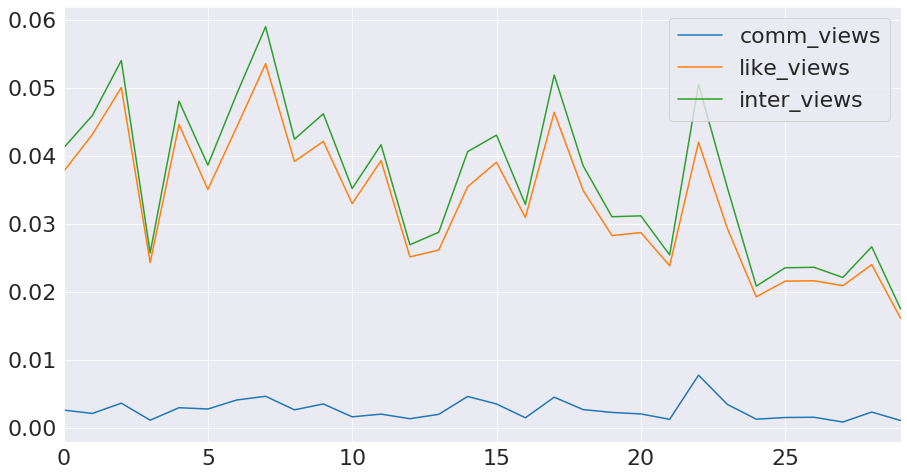

In [53]:
vids_df.head(30)[['comm_views','like_views','inter_views']].plot.line(figsize=(15,8))

In [54]:
sents_df.head(5)

,VidID,mean_sent,Published
27,36Kaj2_vqeo,0.168121,2019-04-09 08:44:19+00:00
7,inBhr8E-iA0,0.142588,2019-04-22 10:03:27+00:00
20,VL7AjoWG_SI,0.205229,2019-06-04 11:36:24+00:00
14,YQt1_b56OqQ,0.166721,2019-06-10 10:56:59+00:00
19,yUJ948S0zCM,0.183459,2019-06-14 08:50:46+00:00


In [55]:
vids_df.head(5)

,VidID,ChannelID,VidTitle,VidDescription,VidPublished,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,comm_views,like_views,dislike_views,inter_views
0,-TP0FuN5Saw,UC31J-GnK6dQY0p2orKnMN_Q,Shammi Vs Jayden!!,We always get in arguments over who is the bet...,2020-01-21T10:00:00.000Z,176682,6659.0,164.0,0,453.0,0.002564,0.037689,0.000928,0.041181
1,zxIYwoig4c8,UC31J-GnK6dQY0p2orKnMN_Q,Extreme Car Pulling behind G Wagon!!,I think I'll give it another year before I app...,2020-01-17T08:23:20.000Z,139309,6016.0,100.0,0,289.0,0.002075,0.043185,0.000718,0.045977
2,5Ek2uaKiBbw,UC31J-GnK6dQY0p2orKnMN_Q,Shammi New Years Eve Party!!,Celebrating the last day of the decade in Styl...,2020-01-07T10:48:31.000Z,190522,9542.0,74.0,0,683.0,0.003585,0.050083,0.000388,0.054057
3,iaB1wgW19Js,UC31J-GnK6dQY0p2orKnMN_Q,Shammi Vlogs 2019 BEST MOMENTS!!,Thanks so much to everyone for your Support in...,2019-12-28T07:45:02.000Z,215636,5239.0,76.0,0,233.0,0.001081,0.024296,0.000352,0.025729
4,TF2jxwObEoI,UC31J-GnK6dQY0p2orKnMN_Q,We Surprised him with the Worlds Biggest Present!,In the spirit of Christmas we decided to Gift ...,2019-12-20T07:45:55.000Z,135111,6029.0,72.0,0,394.0,0.002916,0.044623,0.000533,0.048072


In [56]:
# Create a new df with just the variables of interest
samp_vids = pd.merge(sents_df,vids_df.head(30)[['VidID','viewCount','comm_views','like_views','dislike_views','inter_views']],on='VidID',left_index=True)

In [57]:
samp_vids.head(5)

,VidID,mean_sent,Published,viewCount,comm_views,like_views,dislike_views,inter_views
29,36Kaj2_vqeo,0.168121,2019-04-09 08:44:19+00:00,394810,0.001031,0.016094,0.000344,0.017469
28,inBhr8E-iA0,0.142588,2019-04-22 10:03:27+00:00,151458,0.002278,0.023993,0.000350,0.026621
27,VL7AjoWG_SI,0.205229,2019-06-04 11:36:24+00:00,638865,0.000806,0.020879,0.000421,0.022106
26,YQt1_b56OqQ,0.166721,2019-06-10 10:56:59+00:00,215306,0.001509,0.021616,0.000474,0.023599
25,yUJ948S0zCM,0.183459,2019-06-14 08:50:46+00:00,314859,0.001474,0.021562,0.000492,0.023528


In [58]:
samp_vids = samp_vids.sort_values(by='Published').reset_index().drop(axis=1,labels='index')

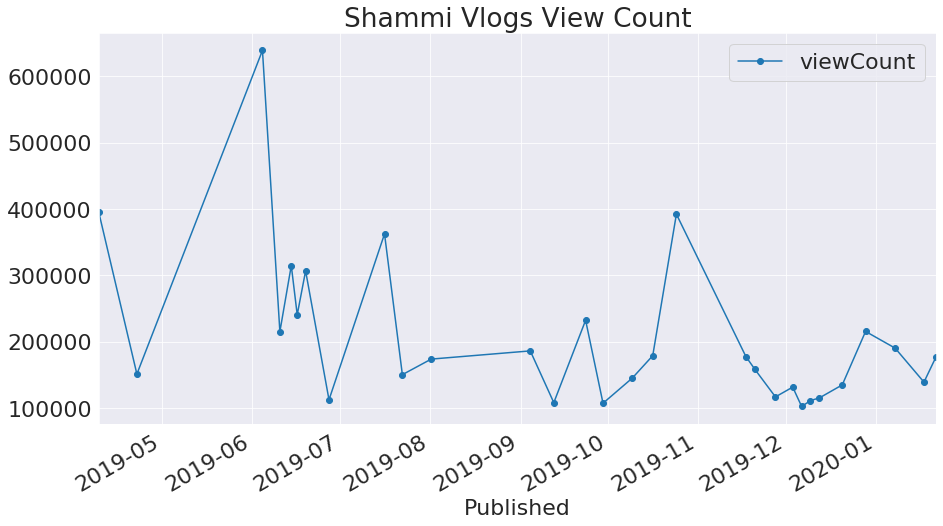

In [59]:
samp_vids.plot.line(x='Published',y=['viewCount'],figsize=(15,8), marker='o',logy=False, title='Shammi Vlogs View Count')

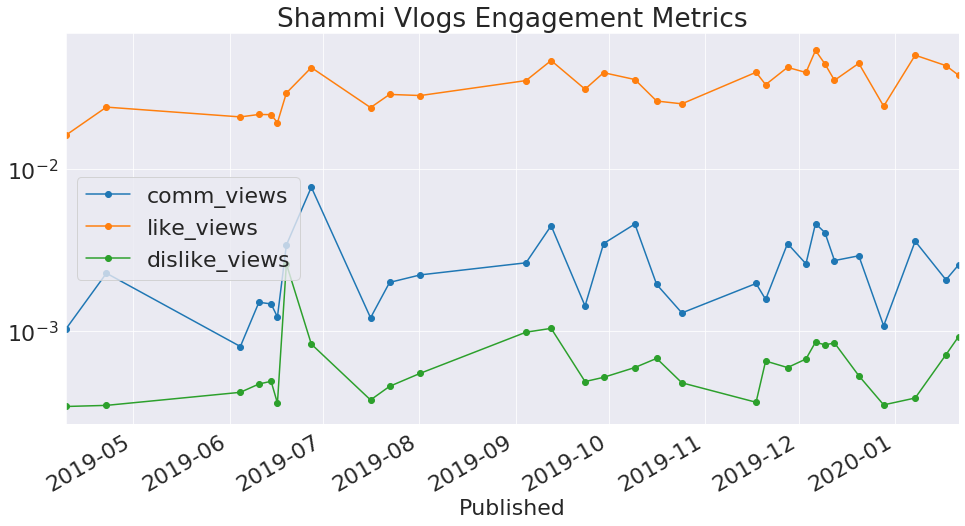

In [60]:
samp_vids.plot.line(x='Published',y=['comm_views','like_views','dislike_views'],figsize=(16,8), marker='o',logy=True,title='Shammi Vlogs Engagement Metrics')

See if we can't get some details on the spike before 2019-07

In [61]:
samp_vids.iloc[7]

VidID                          I92tlqPvaVw
mean_sent                         0.198246
Published        2019-06-27 07:16:27+00:00
viewCount                           112682
comm_views                      0.00771197
like_views                       0.0420298
dislike_views                  0.000834206
inter_views                       0.050576
Name: 7, dtype: object

In [62]:
vids_df.iloc[22]

VidID                                                   I92tlqPvaVw
ChannelID                                  UC31J-GnK6dQY0p2orKnMN_Q
VidTitle                                    READING HATE COMMENTS!!
VidDescription    If you want a shout out in my next Vlog write ...
VidPublished                               2019-06-27T07:16:27.000Z
viewCount                                                    112682
likeCount                                                      4736
dislikeCount                                                     94
favoriteCount                                                     0
commentCount                                                    869
comm_views                                               0.00771197
like_views                                                0.0420298
dislike_views                                           0.000834206
inter_views                                                0.050576
Name: 22, dtype: object

Looks like the "Reading Hate comments" video has the greatest interaction on the video

In [63]:
vid_titles = vids_df['VidTitle']

In [64]:
lowered_titles = []
for vidt in vid_titles:
    lowered_titles.append(vidt.lower())

In [65]:
lowered_titles[0:10]

['shammi vs jayden!!',
 'extreme car pulling behind g wagon!!',
 'shammi new years eve party!!',
 'shammi vlogs 2019 best moments!!',
 'we surprised him with the worlds biggest present!',
 'i locked them outside for the night!!',
 'last to leave onion cutting challenge!!',
 '200k subscribers!!',
 'we messed up!!',
 'big announcement!!']

In [66]:
vids_df['VidTitle'].head(5)

0                                   Shammi Vs Jayden!!
1                 Extreme Car Pulling behind G Wagon!!
2                         Shammi New Years Eve Party!!
3                     Shammi Vlogs 2019 BEST MOMENTS!!
4    We Surprised him with the Worlds Biggest Present!
Name: VidTitle, dtype: object

In [67]:
hate_idxs = []
for idx,title in enumerate(lowered_titles):
    if 'hate' in title:
        hate_idxs.append(idx)

In [68]:
hate_idxs

[22, 239, 431, 507, 906]

In [69]:
vids_df['VidTitle'][hate_idxs[2]]

'POOR STORM  HE HATED THAT BUT IT HAD TO BE DONE! Day 014 (01/14/20)'

In [70]:
vids_df.iloc[431]

VidID                                                   YxBVkpBMw24
ChannelID                                  UCgneYJoJkfJLUDDnDif-u_Q
VidTitle          POOR STORM  HE HATED THAT BUT IT HAD TO BE DON...
VidDescription    #ALWAYSGABBY #SOPHIESLIFE #DAYBYDAYVLOGS\n\nT ...
VidPublished                               2020-01-15T08:30:00.000Z
viewCount                                                     17403
likeCount                                                       656
dislikeCount                                                     19
favoriteCount                                                     0
commentCount                                                    201
comm_views                                                0.0115497
like_views                                                0.0376947
dislike_views                                            0.00109177
inter_views                                               0.0503361
Name: 431, dtype: object

No other title with 'hate' with respect to hate comments in our list

Let's see if another channel can reveal some more details

In [71]:
channels_df

,ChannelTitle,ChannelID,ChannelDescription
0,Karolina Protsenko Vlog,UCV8WWGbh60HcnLsQjl1XU0Q,NaN
1,Shammi Vlogs,UC31J-GnK6dQY0p2orKnMN_Q,Australian social media entertainer living in ...
2,Kylie Jenner,UCWkYXtnAuu7VTLPwUcRSB6A,Exclusive videos from Kylie Jenner. Behind-the...
3,Glamazontay Vlogs,UCn01P04z4hqVykTo_r12UMg,Hey Im Octavia a 24 year Old College Graduate ...
4,CaseyNeistat,UCtinbF-Q-fVthA0qrFQTgXQ,"Hi, I live in New York City and love YouTube. ..."
5,Ava Jules Vlogs,UCRmzmRFJ-gko2G6uwKdMPbg,NaN
6,Vlog No Copyright Music,UCEickjZj99-JJIU8_IJ7J-Q,Vlog No Copyright Music are dedicated to shari...
7,Aspyn and Parker,UCxjZe0qTFXh6jGm54LFWEDw,Hey guys! These vlogs are about our lives and ...
8,AlishaMarieVlogs,UCF1Q_zp3Eh3nuEHvMbdKkqg,Hi I'm Alisha Marie and this vlog channel is a...
9,Tiffany Ferguson Vlogs,UCC7wG93qepOsGGoV5t-WImA,HI my name is Tiffany and these are my vlogs! ...


CaiseyNeistat is a good example of a popular and successful blogger:

In [72]:
channels_df.iloc[4]

ChannelTitle                                               CaseyNeistat
ChannelID                                      UCtinbF-Q-fVthA0qrFQTgXQ
ChannelDescription    Hi, I live in New York City and love YouTube. ...
Name: 4, dtype: object

In [73]:
test_cid = channels_df.iloc[4]['ChannelID']
test_vids_list = list(vids_df[vids_df['ChannelID'] == test_cid]['VidID'])

# Get just the comments from the test case
test_df = comms_df[comms_df['videoId'].isin(test_vids_list)]

test_commtext = test_df['textDisplay']

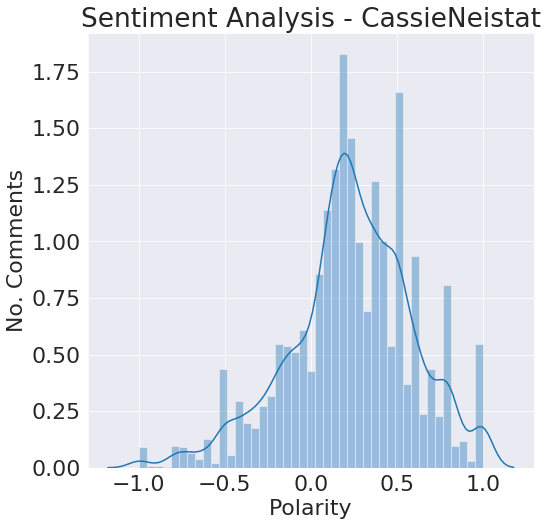

In [74]:
from textblob import TextBlob
import numpy as np

# Convert to list
data = test_commtext.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

data = [deEmojify(comm) for comm in data]

def clean_text(text):
    # lower case:
    text = text.lower()
    # replace new line and return with space
    text = text.replace("\n", " ").replace("\r"," ")
    # replace punctuation marks with space
    punc_list = '!"#$%&()*+,-./:;<=>?@[\]{}|^_~' + '0123456789'
    t=str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)
    # replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    return text

blobs = []
for item in data:
    blobs.append(TextBlob(item))
    
sents = np.array([blob.sentiment.polarity for blob in blobs])

# Remove all neutral sentiments as they do not contribute much to gauging overall sentiment
sents_rm_neu_cassie = [x for x in sents if x != 0]

plt.figure(figsize=(8, 8))
plt.title('Sentiment Analysis - CassieNeistat')
plt.xlabel('Polarity')
plt.ylabel('No. Comments')
sns.set_style('darkgrid')
sns.distplot(sents_rm_neu_cassie,kde=True)

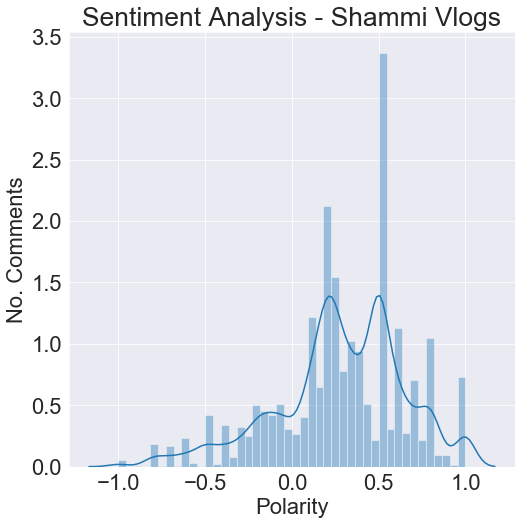

In [75]:
plt.figure(figsize=(8, 8))
plt.title('Sentiment Analysis - Shammi Vlogs')
plt.xlabel('Polarity')
plt.ylabel('No. Comments')
sns.set_style('darkgrid')
sns.distplot(sents_rm_neu,kde=True)

C:\ProgramData\Anaconda3\envs\insight\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


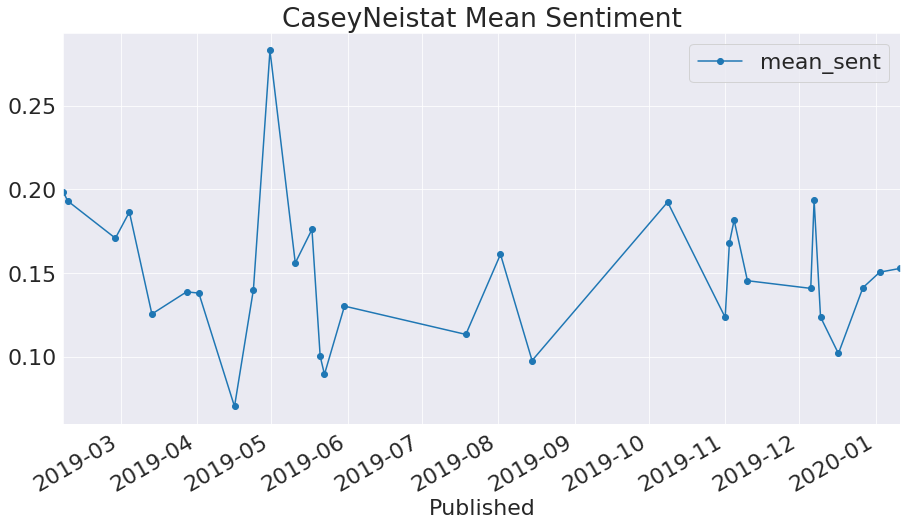

In [76]:
test_df['Sentiment_Polarity'] = sents

vid_ids = list(set(test_df['videoId']))
sent_vids = []
for vid_ID in vid_ids:
    sent_vids.append(np.array(test_df[test_df['videoId'] == vid_ID]['Sentiment_Polarity']))

sent_vids_mean = [np.mean(sent_vids[i]) for i in range(0,len(sent_vids))]
sents_df = pd.DataFrame({'VidID':vid_ids, 'mean_sent':sent_vids_mean})
vids_df = pd.read_csv(insight_dir+'data\\processed\\videos_top30_df.csv', index_col=0)

import dateparser
published = []
for vid_id in sents_df['VidID']:
    published.append(dateparser.parse(vids_df[vids_df['VidID'] == vid_id]['VidPublished'].values[0]))

sents_df['Published'] = published

sents_df = sents_df.sort_values(by='Published')

vids_df['comm_views'] = vids_df['commentCount']/vids_df['viewCount']
vids_df['like_views'] = vids_df['likeCount']/vids_df['viewCount']
vids_df['dislike_views'] = vids_df['dislikeCount']/vids_df['viewCount']
vids_df['inter_views'] = (vids_df['likeCount']+vids_df['dislikeCount']+vids_df['commentCount'])/vids_df['viewCount']

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

sents_df.plot.line(x='Published',y='mean_sent',figsize=(15,8), marker='o',title='CaseyNeistat Mean Sentiment')

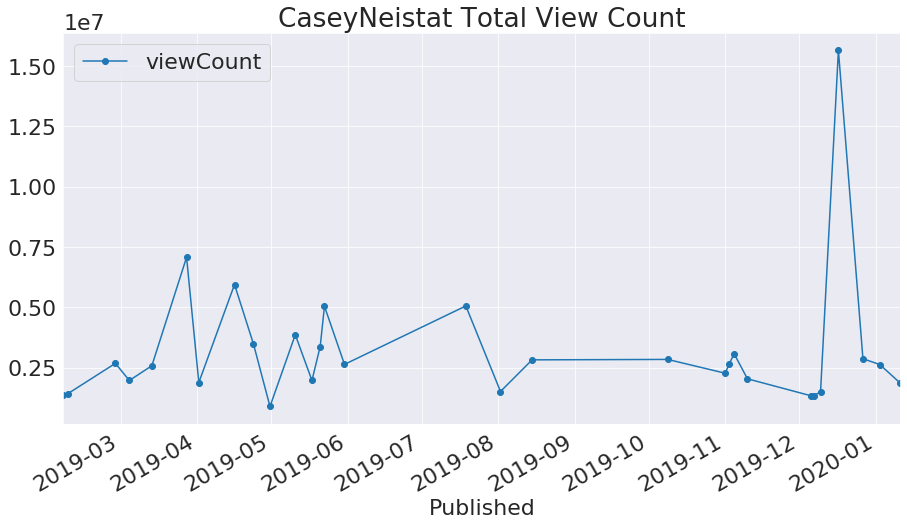

In [77]:
# Create a new df with just the variables of interest
samp_vids = pd.merge(sents_df,vids_df[['VidID','viewCount','comm_views','like_views','dislike_views','inter_views']],on='VidID',left_index=True)
samp_vids = samp_vids.sort_values(by='Published').reset_index().drop(axis=1,labels='index')
samp_vids.plot.line(x='Published',y=['viewCount'],figsize=(15,8), marker='o',logy=False, title='CaseyNeistat Total View Count')

In [ ]:
samp_vids.plot.line(x='Published',y=['comm_views','like_views','dislike_views'],figsize=(16,8), marker='o',logy=True,title='CaseyNeistat Engagement Metrics')